# Example of running and analysing the energy system model of the NL

In [1]:
import calliope
import pandas as pd

calliope.set_log_verbosity("INFO", include_solver_output=True)

# 1. Reference case
## 1.1. Create and solve the model

In [8]:
model = calliope.read_yaml('model/model.yaml')

[2025-12-02 16:20:00] INFO     Math init | loading pre-defined math.
[2025-12-02 16:20:00] INFO     Math init | loading math files {'milp', 'spores', 'storage_inter_cluster', 'base', 'operate'}.
[2025-12-02 16:20:00] INFO     Model: preprocessing data
[2025-12-02 16:20:00] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-02 16:20:01] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:20:01] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:20:01] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:20:01] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:20:01] INFO     Model: initialisation complete


In [9]:
model.inputs.sink_use_equals.to_series().dropna()

timesteps            nodes  techs       
2024-10-01 00:00:00  NLD    demand_power    23513.333333
2024-10-01 01:00:00  NLD    demand_power    22478.083333
2024-10-01 02:00:00  NLD    demand_power    21627.416667
2024-10-01 03:00:00  NLD    demand_power    21228.416667
2024-10-01 04:00:00  NLD    demand_power    21190.583333
                                                ...     
2025-09-30 19:00:00  NLD    demand_power    29335.833333
2025-09-30 20:00:00  NLD    demand_power    31345.000000
2025-09-30 21:00:00  NLD    demand_power    30769.416667
2025-09-30 22:00:00  NLD    demand_power    27631.916667
2025-09-30 23:00:00  NLD    demand_power    24969.083333
Name: sink_use_equals, Length: 8759, dtype: float64

In [10]:
model.build()
model.solve()

[2025-12-02 16:20:08] INFO     Model: backend build starting
[2025-12-02 16:20:08] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-12-02 16:20:09] INFO     Optimisation Model | variables | Generated.
[2025-12-02 16:20:11] INFO     Optimisation Model | global_expressions | Generated.
[2025-12-02 16:20:15] INFO     Optimisation Model | constraints | Generated.
[2025-12-02 16:20:15] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-12-02 16:20:15] INFO     Optimisation Model | objectives | Generated.
[2025-12-02 16:20:15] INFO     Model: backend build complete
[2025-12-02 16:20:19] INFO     Optimisation model | starting model in base mode.
[2025-12-02 16:20:24] DEBUG    Read LP format model from file C:\Users\yaowa\AppData\Local\Temp\tmpi5r66n34.pyomo.lp
Reading time = 0.70 seconds
x1: 192690 rows, 122626 columns, 359105 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossove

## 1.2. Do a first sense-check of the results

In [11]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2024-10-01 00:00:00       0.012627
1   NLD    power 2024-10-01 01:00:00       0.012627
2   NLD    power 2024-10-01 02:00:00        0.00175
3   NLD    power 2024-10-01 03:00:00        0.00175
4   NLD    power 2024-10-01 04:00:00        0.00175

<Axes: >

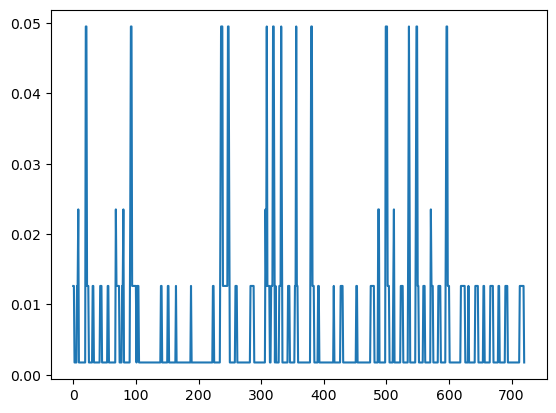

In [13]:
# Create a Date Range to select a few days in November to inspect visually
days_of_interest = pd.date_range('2024-10-01','2024-10-31',freq='h') 
# Plot the days of interest
balance_price['system_balance'].loc[balance_price['timesteps'].isin(days_of_interest)].plot()

Because the model is very simple, the price always matches the price of the CCGT unless renewables are capable of meeting demand by themselves. We can check that the value shown in the shadow price is indeed the marginal cost of the CCGT by performing a few steps. The marginal cost is, in fact, the ratio between the variable co

In [14]:
variable_costs = model.results.cost_operation_variable.to_series().dropna()
variable_costs.head()

nodes  techs  costs     timesteps          
NLD    ccgt   monetary  2024-10-01 00:00:00    7.278228e-08
                        2024-10-01 01:00:00    7.595118e-08
                        2024-10-01 02:00:00    5.799900e-08
                        2024-10-01 03:00:00    5.818620e-08
                        2024-10-01 04:00:00    5.825546e-08
Name: cost_operation_variable, dtype: float64

In [15]:
generation = model.results.flow_out.to_series().dropna()
generation.head()

nodes  techs  carriers  timesteps          
NLD    ccgt   power     2024-10-01 00:00:00    0.000001
                        2024-10-01 01:00:00    0.000002
                        2024-10-01 02:00:00    0.000001
                        2024-10-01 03:00:00    0.000001
                        2024-10-01 04:00:00    0.000001
Name: flow_out, dtype: float64

In [16]:
# If we calculate the marginal generation costs per generator type,
# we should see an equivalence between the shadow price in any given
# hour and the marginal cost of the marginal generator in the merit order
marginal_generation_costs = variable_costs/generation
marginal_generation_costs.head()

nodes  techs  costs     timesteps            carriers
NLD    ccgt   monetary  2024-10-01 00:00:00  power       0.049503
                        2024-10-01 01:00:00  power       0.049503
                        2024-10-01 02:00:00  power       0.049503
                        2024-10-01 03:00:00  power       0.049503
                        2024-10-01 04:00:00  power       0.049503
dtype: float64

As expected, the marginal cost of CCGT equals the shadow price. CCGT is the marginal generator in the merit order.

In [19]:
# To check the merit order, we may look at a particular timestep
# and at the list of generators producing in that timestep in ascending cost order.
# The per-timestep selection is easier done before transforming to a Pandas series.
marginal_generation_costs_xr = model.results.cost_operation_variable / model.results.flow_out
# We select a specific hour of the year
my_timestep = '2024-10-01 04:00:00'
# And we select only generators, excluding curtailment and other techs
gen_techs = ['solar_pv' ,'wind_onshore','hydro', 'ccgt', 'nuclear'] 
# We can now inspect the marginal generation cost in that timestep
marginal_generation_cost_in_timestep = marginal_generation_costs_xr.sel(timesteps=my_timestep, carriers='power', costs='monetary', techs=gen_techs)
marginal_generation_cost_in_timestep.to_series().fillna(0).sort_values()

nodes  techs       
NLD    solar_pv        0.000011
       wind_onshore    0.001508
       hydro           0.001750
       nuclear         0.012627
       ccgt            0.049503
dtype: float64

We see that CCGT, whose marginal generation costs match the shadow price, is the marginal generator. Nuclear isn't used; if it were, the shadow price would be higher and equal to its marginal cost. This can be double-checked by looking at the dispatch plots.

## 1.3. Export the results for further analysis at any later moment

In [20]:
# It is helpful to store the model results as a whole in NetCDF format, which Calliope can import back
# at any later time. 
model.to_netcdf('results/default_results.nc')

In [22]:
# Alternatively, results can be exported as a series of .csv files for inspection and analysis in Excel or
# other software that may benefit from .csv data
model.to_csv('results/default_results_csv')

## 1.4. Produce some visualisations

In this example, we provide some pre-made plotting functionalities in the 'plotting_utilities.py' file, which you can import and apply as well as use as an example for making your own custom plots.

In [23]:
# Import some pre-made plotting functionalities as an example. You can use these, make your own, or simply
# create plots with your favourite Python library or non-Python tool, such as Excel
from plotting_utilities import plot_dispatch,plot_load_duration_curve

In [24]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/default_results.nc', plot_export_path='results/default_dispatch.html')

[2025-12-02 16:24:49] INFO     Model: preprocessing data (reentry)
[2025-12-02 16:24:49] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-02 16:24:49] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:24:49] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:24:50] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:24:50] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:24:50] INFO     Model: initialisation complete


In [25]:
# For generating load duration curves (LDCs), instead, we first need to import back the model results,
# then extract the time-varing variable of interest
model = calliope.read_netcdf('results/default_results.nc')

[2025-12-02 16:25:55] INFO     Model: preprocessing data (reentry)
[2025-12-02 16:25:55] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-02 16:25:55] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:25:55] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:25:55] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:25:55] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-02 16:25:55] INFO     Model: initialisation complete


In [26]:
# Suppose we want to plot the LDC of the dispatch of the CCGT power plant
ccgt_dispatch = model.results.flow_out.sel(techs='ccgt').to_series().dropna()
ccgt_dispatch.head()

nodes  carriers  timesteps          
NLD    power     2024-10-01 00:00:00    0.000001
                 2024-10-01 01:00:00    0.000002
                 2024-10-01 02:00:00    0.000001
                 2024-10-01 03:00:00    0.000001
                 2024-10-01 04:00:00    0.000001
Name: flow_out, dtype: float64

In [27]:
plot_load_duration_curve(dataframe=ccgt_dispatch.to_frame(), 
                         plot_export_path='results/default_ccgt_ldc.html', 
                         y_label='Flow out (MWh)')

In [28]:
# Or we may want the LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

In [29]:
# Obtain demand from input
demand = model.inputs.sink_use_equals.sel(techs='demand_power').to_series().dropna()

# Get the dispatch of renewables
solar_pv_dispatch = model.results.flow_out.sel(techs='solar_pv').to_series().dropna()
wind_onshore_dispatch = model.results.flow_out.sel(techs='wind_onshore').to_series().dropna()

# Calculate the residual load (load minus renewable generation)
residual_load = demand - (solar_pv_dispatch + wind_onshore_dispatch)
residual_load.head()

timesteps            nodes  carriers
2024-10-01 00:00:00  NLD    power       18482.351060
2024-10-01 01:00:00  NLD    power       17124.547769
2024-10-01 02:00:00  NLD    power       15988.931413
2024-10-01 03:00:00  NLD    power       15260.833297
2024-10-01 04:00:00  NLD    power       14931.385135
dtype: float64

In [30]:
# Plot the LDC of the residual load
plot_load_duration_curve(dataframe=residual_load.to_frame(name='Residual Load (MWh)'),
                         plot_export_path='results/default_residual_load.html',
                         y_label='Residual Load (MWh)')


## 1.5. Cost recovery

In [31]:
gen_techs = ['solar_pv','wind_onshore', 'hydro', 'ccgt', 'nuclear'] 

In [32]:
# Flow out for all gen techs in one go
dispatch = (
    model.results.flow_out
    .sel(techs=gen_techs, carriers='power')   # carriers only if present
    .to_series()                              # -> Series with index (nodes, techs, timesteps)
    .unstack('techs')                         # techs become columns
    .reset_index()                            # timesteps as column, keep nodes
)

dispatch.head()


techs nodes           timesteps    solar_pv  wind_onshore         hydro  \
0       NLD 2024-10-01 00:00:00  549.950238   4481.032035  17076.999994   
1       NLD 2024-10-01 01:00:00  530.303485   4823.232080  17076.999995   
2       NLD 2024-10-01 02:00:00  493.366528   5145.118725  15988.931441   
3       NLD 2024-10-01 03:00:00  459.898204   5507.685166  15260.833324   
4       NLD 2024-10-01 04:00:00  331.850088   5927.348110  14931.385162   

techs      ccgt      nuclear  
0      0.000001  1405.351069  
1      0.000002    47.547777  
2      0.000001     0.000005  
3      0.000001     0.000005  
4      0.000001     0.000005

In [33]:
# Shadow price dataframe
balance_price = (
    model.results.shadow_price_system_balance
    .to_series().reset_index()
)
balance_price

# Merge price into dispatch
df = balance_price.merge(dispatch, on='timesteps', how='left')
df.head()

nodes_x carriers           timesteps  shadow_price_system_balance nodes_y  \
0     NLD    power 2024-10-01 00:00:00                     0.012627     NLD   
1     NLD    power 2024-10-01 01:00:00                     0.012627     NLD   
2     NLD    power 2024-10-01 02:00:00                     0.001750     NLD   
3     NLD    power 2024-10-01 03:00:00                     0.001750     NLD   
4     NLD    power 2024-10-01 04:00:00                     0.001750     NLD   

     solar_pv  wind_onshore         hydro      ccgt      nuclear  
0  549.950238   4481.032035  17076.999994  0.000001  1405.351069  
1  530.303485   4823.232080  17076.999995  0.000002    47.547777  
2  493.366528   5145.118725  15988.931441  0.000001     0.000005  
3  459.898204   5507.685166  15260.833324  0.000001     0.000005  
4  331.850088   5927.348110  14931.385162  0.000001     0.000005

In [34]:
# Revenue per tech = price * dispatch (hourly)
for tech in gen_techs:
    df[f'{tech}_revenue'] = df[tech] * df['shadow_price_system_balance']

# Total (modelled-period) revenue per tech
revenue = df[[f'{t}_revenue' for t in gen_techs]].sum()
revenue.index = revenue.index.str.replace('_revenue', '', regex=False)
revenue.name = 'revenue'
revenue

solar_pv        1.512703e+05
wind_onshore    4.172146e+05
hydro           1.314555e+06
ccgt            1.156435e+05
nuclear         3.926367e+05
Name: revenue, dtype: float64

In [35]:
cost = (
    model.results.cost
    .sel(techs=gen_techs)   # we only care about these
    .sum('nodes')           # if you only have one node, this just drops the dim
    .to_series()
)
cost = cost.droplevel('costs')                # or just drop the level
cost.name = 'cost'
cost


techs
solar_pv           563.242081
wind_onshore     84593.060763
hydro           194382.552814
ccgt            115643.465340
nuclear         174523.867706
Name: cost, dtype: float64

In [36]:
# calculate profit and cost recovery ratio
summary = pd.concat([revenue, cost], axis=1)
summary['profit'] = summary['revenue'] - summary['cost']
summary['cost_recovery_ratio'] = summary['revenue'] / summary['cost']  # >1 means full recovery
summary

revenue           cost        profit  cost_recovery_ratio
solar_pv      1.512703e+05     563.242081  1.507070e+05           268.570628
wind_onshore  4.172146e+05   84593.060763  3.326216e+05             4.932020
hydro         1.314555e+06  194382.552814  1.120173e+06             6.762723
ccgt          1.156435e+05  115643.465340 -1.185615e-03             1.000000
nuclear       3.926367e+05  174523.867706  2.181129e+05             2.249760

# 2. Carbon tax case
## 2.1. Reload the model with a carbon tax scenario and re-solve

In [19]:
model = calliope.read_yaml('model/model.yaml',scenario='carbon_tax')

[2025-11-10 17:18:29] INFO     (scenarios, carbon_tax ) | Applying the following overrides: ['carbon_tax'].
[2025-11-10 17:18:29] INFO     Math init | loading pre-defined math.
[2025-11-10 17:18:29] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:18:29] INFO     Model: preprocessing data
[2025-11-10 17:18:29] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:29] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO

In [20]:
model.build()
model.solve()

[2025-11-10 17:18:29] INFO     Model: backend build starting
[2025-11-10 17:18:30] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:18:30] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:18:30] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:18:32] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:18:32] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:18:32] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:18:32] INFO     Model: backend build complete
[2025-11-10 17:18:32] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:18:32] DEBUG    Read LP format model from file /tmp/tmpik4gym7h.pyomo.lp
Reading time = 0.03 seconds
x1: 14876 rows, 8928 columns, 26032 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasib

## 2.2. Analyse how prices and operation change

In [21]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2019-01-01 00:00:00       0.025526
1   NLD    power 2019-01-01 01:00:00       0.025526
2   NLD    power 2019-01-01 02:00:00       0.025526
3   NLD    power 2019-01-01 03:00:00       0.025526
4   NLD    power 2019-01-01 04:00:00       0.025526

We see that the shadow price changes and it is higher than in the default case, as expected.
We can visualise its LDC again:

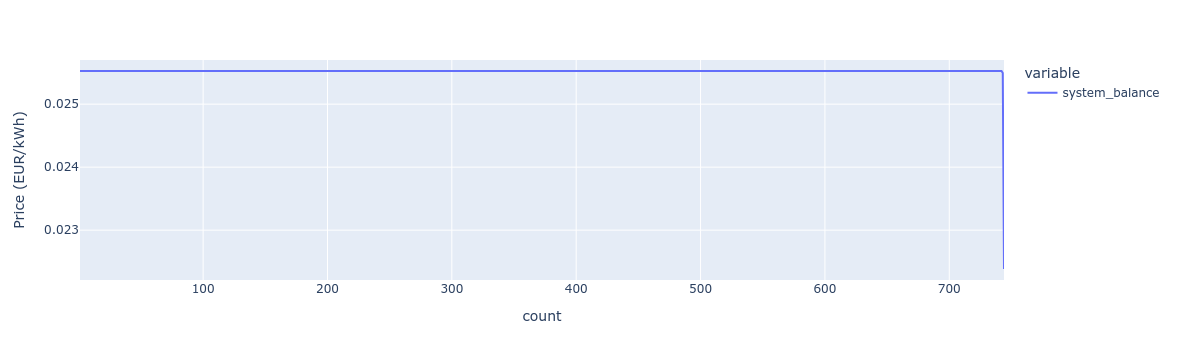

In [22]:
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

In [23]:
# To calculate the merit order, we want to look at a particular timestep
# and at the list of generators producing in that timestep in ascending cost order.
# The per-timestep selection is easier done before transforming to a Pandas series.
marginal_generation_costs_xr = model.results.cost_operation_variable / model.results.flow_out
my_timestep = '2019-01-01 04:00:00'
gen_techs = ['solar_pv' ,'wind_offshore', 'wind_onshore', 'ccgt', 'nuclear'] # We select only generators, excluding curtailment and other techs
marginal_generation_cost_in_timestep = marginal_generation_costs_xr.sel(timesteps=my_timestep, carriers='power', techs=gen_techs)
marginal_generation_cost_in_timestep.to_series().fillna(0).sort_values()

nodes  techs          costs   
NLD    solar_pv       co2         0.000000
                      monetary    0.000000
       wind_offshore  co2         0.000000
                      monetary    0.000000
       wind_onshore   co2         0.000000
       nuclear        co2         0.000000
       ccgt           co2         0.000351
       wind_onshore   monetary    0.001508
       ccgt           monetary    0.007982
       nuclear        monetary    0.022375
dtype: float64

We see that, in this case, the shadow price matches the marginal cost of the nuclear power plant. Nuclear is the marginal generator

In [24]:
model.to_netcdf('results/carbontax_results.nc')

As before, you may use the plotting utilities or your own custom code

In [32]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/carbontax_results.nc', plot_export_path='results/carbontax_dispatch.html')

[2025-11-10 17:23:23] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:23:23] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:23:23] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     Model: initialisation complete


Note: The installed capacity of each power plant hasn't changed: nuclear was there in the default scenario, and it's here again, given that the system design is fixed and we only look at the dispatch. However, nuclear power is now in the dispatch, which wasn't the case before.
This is the effect of the carbon tax, which is making CCGT less attractive!

# 3. Renewables growth case
## 3.1. Reload the model with a scenario that forces a higher capacity of renewables and re-solve

In [26]:
model = calliope.read_yaml('model/model.yaml',scenario='more_renewables')

[2025-11-10 17:18:33] INFO     Loading overrides from scenario: more_renewables 
[2025-11-10 17:18:33] INFO     (scenarios, more_renewables ) | Applying the following overrides: ['higher_solar', 'higher_wind'].
[2025-11-10 17:18:33] INFO     Math init | loading pre-defined math.
[2025-11-10 17:18:33] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:18:33] INFO     Model: preprocessing data
[2025-11-10 17:18:33] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:34] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:34] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:34] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:34] INFO     input data `name` not 

In [27]:
model.build()
model.solve()

[2025-11-10 17:18:34] INFO     Model: backend build starting
[2025-11-10 17:18:34] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:18:34] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:18:35] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:18:36] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:18:36] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:18:36] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:18:36] INFO     Model: backend build complete
[2025-11-10 17:18:37] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:18:37] DEBUG    Read LP format model from file /tmp/tmpicbhlh16.pyomo.lp
Reading time = 0.02 seconds
x1: 14876 rows, 8928 columns, 26032 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasib

In [28]:
model.to_netcdf('results/more_vres.nc')

## 3.1. Visualise the change in the system operation and the impact on prices

[2025-11-10 17:24:39] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:24:39] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:24:39] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     Model: initialisation complete


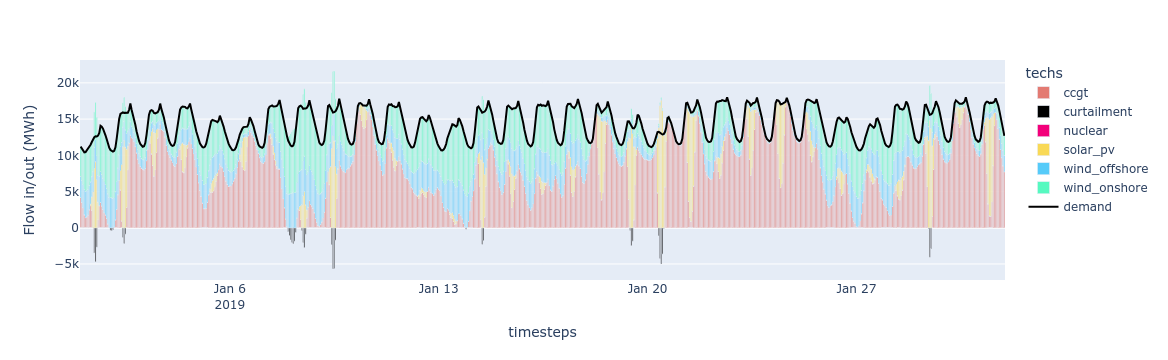

In [33]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/more_vres.nc', plot_export_path='results/more_vres.html')

In [30]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2019-01-01 00:00:00       0.007982
1   NLD    power 2019-01-01 01:00:00       0.007982
2   NLD    power 2019-01-01 02:00:00       0.007982
3   NLD    power 2019-01-01 03:00:00       0.007982
4   NLD    power 2019-01-01 04:00:00       0.007982

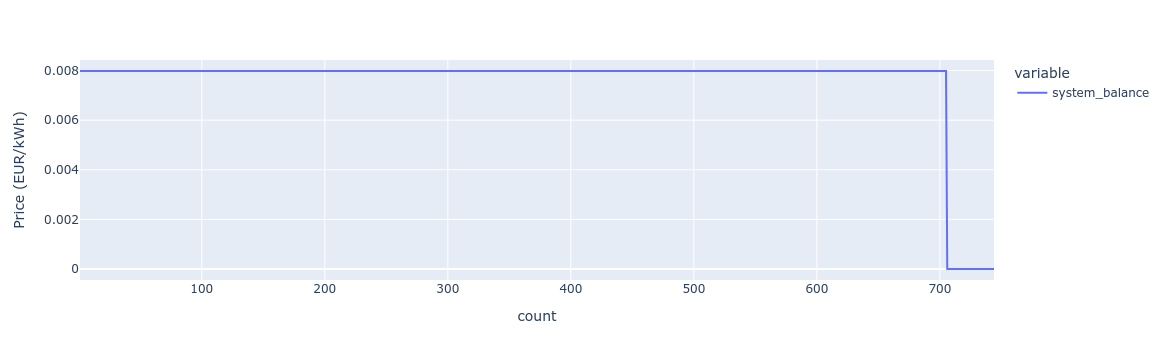

In [31]:
# LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

# 4. Generation capacity outage case
## 4.1 Reload the model with a scenario that forces a lower capacity of CCGT and re-solve

In [54]:
model = calliope.read_yaml('model/model.yaml',scenario='generation_outage')

[2025-11-10 17:38:31] INFO     Loading overrides from scenario: generation_outage 
[2025-11-10 17:38:31] INFO     (scenarios, generation_outage ) | Applying the following overrides: ['lower_ccgt'].
[2025-11-10 17:38:31] INFO     Math init | loading pre-defined math.
[2025-11-10 17:38:31] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:38:31] INFO     Model: preprocessing data
[2025-11-10 17:38:31] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:38:32] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `name` not defined in mo

In [55]:
model.build()
model.solve()

[2025-11-10 17:38:32] INFO     Model: backend build starting
[2025-11-10 17:38:32] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:38:32] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:38:33] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:38:34] INFO     Model: backend build complete
[2025-11-10 17:38:34] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:38:35] DEBUG    Read LP format model from file /tmp/tmp_383qm9w.pyomo.lp
Reading time = 0.02 seconds
x1: 15620 rows, 10416 columns, 28264 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasi

In [56]:
model.to_netcdf('results/less_generation.nc')

## 4.1. Visualise the change in the system operation and the impact on prices

[2025-11-10 17:38:36] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:38:36] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:38:36] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     Model: initialisation complete


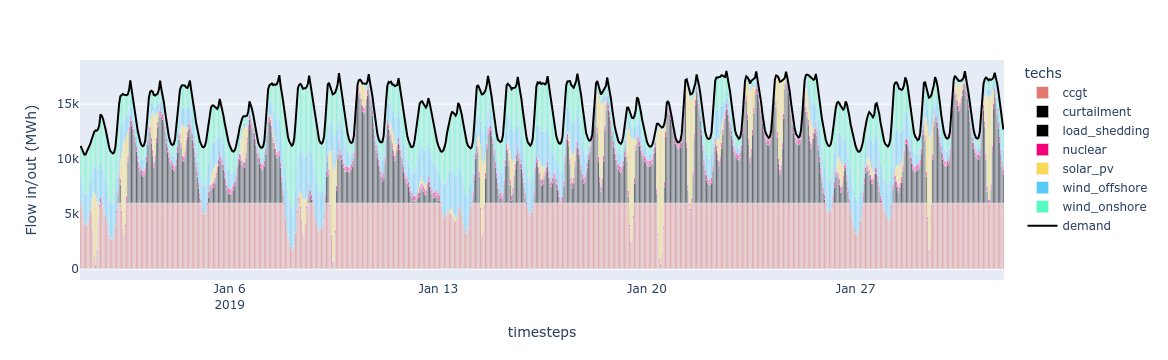

In [57]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/less_generation.nc', plot_export_path='results/less_generation.html')

In [58]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2019-01-01 00:00:00       0.022375
1   NLD    power 2019-01-01 01:00:00       0.007982
2   NLD    power 2019-01-01 02:00:00       0.007982
3   NLD    power 2019-01-01 03:00:00       0.007982
4   NLD    power 2019-01-01 04:00:00       0.007982

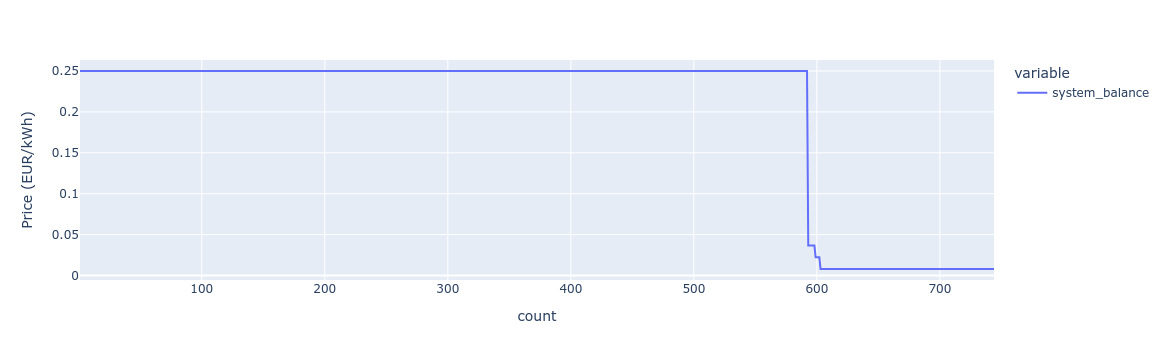

In [59]:
# LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')